# Approach I  - POS + NER + VADER + TF-IDF

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('wordnet')
# Load SpaCy's English language model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
file_path = 'HateXplain-Dataset.xlsx'
df = pd.read_excel(file_path)

print(df.columns)
df.head()

Index(['Unnamed: 0', 'origin_id', 'target', 'text', 'label'], dtype='object')


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
4,4,1179085312976445440,gender,this bitch in whataburger eating a burger with...,hs


In [ ]:
print(f"Dataset size (total number of elements): {df.size}")
print(f"Dataset shape (rows, columns): {df.shape}")

Dataset size (total number of elements): 79525
Dataset shape (rows, columns): (15905, 5)


In [ ]:
# Filter for rows where target is 'ethnicity'
ethnicity_df = df[df['target'] == 'ethnicity']

# Display the shape and first few rows of the filtered dataset
print(f"Ethnicity dataset shape: {ethnicity_df.shape}")
ethnicity_df.head()


Ethnicity dataset shape: (5801, 5)


,Unnamed: 0,origin_id,target,text,label
2,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
3,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
5,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
6,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
7,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Filter for rows where target is NaN
nan_target_df = df[df['target'].isnull()]

# Display the shape and first few rows of the filtered dataset
print(f"NaN target dataset shape: {nan_target_df.shape}")
nan_target_df.head()

NaN target dataset shape: (4850, 5)


,Unnamed: 0,origin_id,target,text,label
0,0,1179055004553900032,NaN,i dont think im getting my baby them white 9 h...,nhs
1,1,1179063826874032128,NaN,we cannot continue calling ourselves feminists...,nhs
11,11,1159278048069464065,NaN,<percent> cotton thigh highs to avoid contact ...,nhs
12,12,1170440965888335874,NaN,oomf a <number> yearl old closet gay and obses...,nhs
14,14,1122734457230774272,NaN,fellas be careful she texting other niggas,nhs


In [ ]:
# Combine the two datasets (ethnicity and NaN target)
final_data = pd.concat([ethnicity_df, nan_target_df])

# Reset the index for the new DataFrame
final_data = final_data.reset_index(drop=True)

# Verify the 'target' column remains intact
print("Unique targets in the final dataset:")
print(final_data['target'].unique())

# Verify the 'label' column remains intact
print("Unique labels in the final dataset:")
print(final_data['label'].unique())

# Display the shape of the final dataset
print(f"Final dataset shape: {final_data.shape}")
final_data.head()

Unique targets in the final dataset:
['ethnicity' nan]
Unique labels in the final dataset:
['nhs' 'hs']
Final dataset shape: (10651, 5)


,Unnamed: 0,origin_id,target,text,label
0,2,1178793830532956161,ethnicity,nawt yall niggers ignoring me,nhs
1,3,1179088797964763136,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,5,13851720,ethnicity,laura loomer raped me while screaming at me in...,hs
3,6,24198545,ethnicity,and this is why i end up with nigger trainee d...,hs
4,7,14567516,ethnicity,nogs jews and dykes how enriching,hs


**Data Preprocessing**




In [ ]:
#drop unwanted columns
final_data = final_data.drop(['Unnamed: 0', 'origin_id'], axis=1)
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,<user> i am bit confused coz chinese ppl can n...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
# Check for missing values in the dataset
print("Missing values per column:")
print(final_data.isnull().sum())


Missing values per column:
target    4850
text         0
label        0
dtype: int64


Since there's no missing values, we r not handling the missing values

In [ ]:
#Remove unnecessary characters, such as mentions (@user), URLs, and special characters,

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply cleaning to the 'text' column
final_data['text'] = final_data['text'].apply(clean_text)

# Display a few cleaned rows
final_data.head()

,target,text,label
0,ethnicity,nawt yall niggers ignoring me,nhs
1,ethnicity,user i am bit confused coz chinese ppl can not...,hs
2,ethnicity,laura loomer raped me while screaming at me in...,hs
3,ethnicity,and this is why i end up with nigger trainee d...,hs
4,ethnicity,nogs jews and dykes how enriching,hs


In [ ]:
#binary label encoding

# Map 'hs' (hate speech, in this context xenophobic) to 1 and 'nhs' (non-hate speech, here non-xenophobic) to 0
final_data['label'] = final_data['label'].map({'hs': 1, 'nhs': 0})

# Verify the transformation
print(final_data['label'].value_counts())


label
0    5387
1    5264
Name: count, dtype: int64


In [ ]:
#Stopwords removal

# Define stop words set
stop_words = set(stopwords.words('english'))

# Add custom stop words
custom_stop_words = {"make", "anything", "user", "say", "right", "someone","number","go","something","know","want","everyone","even","your", "u","look","many","though","im","says","lol","oh","made","got","cause","around","well","put","give","trying","got","calling", "saying","still","us","must","much","lot"}
stop_words.update(custom_stop_words)

# Remove stop words from the 'text' column
final_data['text'] = final_data['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Display a few rows to verify
final_data.head()


,target,text,label
0,ethnicity,nawt yall niggers ignoring,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1
2,ethnicity,laura loomer raped screaming disgusting kike l...,1
3,ethnicity,end nigger trainee doctors speak properly lack...,1
4,ethnicity,nogs jews dykes enriching,1


In [ ]:
#WordCloud

# Combine all text into one string
all_text = ' '.join(final_data['text'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Text Data", fontsize=16)
plt.show()


KeyboardInterrupt: 

## **Approach I - Pos Tagging + NER + Lemmatization + TF-IDF +VADER_Score**

In [ ]:
# Function for POS tagging and extracting key information
def preprocess_xenophobia_text(text):
    doc = nlp(text)
    lemmatized = ' '.join([token.lemma_ for token in doc])
    return {
        "lemmatized": lemmatized,
    }

# Apply preprocessing to your dataset
final_data['preprocessed'] = final_data['text'].apply(preprocess_xenophobia_text)

# Extract components from the preprocessed column
final_data['lemmatized'] = final_data['preprocessed'].apply(lambda x: x['lemmatized'])
# Display the processed dataset
final_data.head()

,target,text,label,lemmatized
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich


In [ ]:
from collections import Counter
import spacy

# Load SpaCy's POS tagging model
nlp = spacy.load("en_core_web_sm")

# Function to count POS tags
def count_pos_tags(text):
    doc = nlp(text)
    pos_counts = Counter([token.pos_ for token in doc])  # Count each POS tag
    return pos_counts

# Apply POS tag counting
final_data['pos_counts'] = final_data['text'].apply(count_pos_tags)

# Extract specific POS counts into separate columns
pos_list = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN']

# Add columns for each POS type
for pos in pos_list:
    final_data[pos] = final_data['pos_counts'].apply(lambda x: x.get(pos, 0))

# Drop intermediate column if no longer needed
final_data.drop('pos_counts', axis=1, inplace=True)

print("POS tag counts added.")


POS tag counts added.


In [ ]:
# Function to extract and count entity types
def count_named_entities(text):
    doc = nlp(text)
    entity_counts = Counter([ent.label_ for ent in doc.ents])  # Count each entity type
    return entity_counts

# Apply NER entity counting
final_data['entity_counts'] = final_data['text'].apply(count_named_entities)

# Define entity types to track
entity_types = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'LANGUAGE']

# Add columns for each entity type
for entity in entity_types:
    final_data[entity] = final_data['entity_counts'].apply(lambda x: x.get(entity, 0))

# Drop intermediate column if no longer needed
final_data.drop('entity_counts', axis=1, inplace=True)

print("NER entity counts added.")


NER entity counts added.


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute VADER sentiment scores
def compute_vader_scores(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

# Apply VADER sentiment analysis
final_data['vader_scores'] = final_data['text'].apply(compute_vader_scores)

# Split VADER scores into individual columns
final_data['vader_neg'] = final_data['vader_scores'].apply(lambda x: x['neg'])
final_data['vader_neu'] = final_data['vader_scores'].apply(lambda x: x['neu'])
final_data['vader_pos'] = final_data['vader_scores'].apply(lambda x: x['pos'])
final_data['vader_compound'] = final_data['vader_scores'].apply(lambda x: x['compound'])

# Drop intermediate column if no longer needed
final_data.drop('vader_scores', axis=1, inplace=True)

print("VADER sentiment scores added.")


VADER sentiment scores added.


# Extracting the NER features

We can skip this step if needed.

In [ ]:
# Function to extract NER features
def extract_ner_features(entities):
    # Initialize features
    contains_norp = 0
    norps_count = 0
    norp_values = []

    # Iterate through entities
    for text, label in entities:
        if label == "NORP":  # Check for NORP (e.g., nationality, religion)
            contains_norp = 1
            norps_count += 1
            norp_values.append(text)

    # Return extracted features
    return {
        "contains_norp": contains_norp,
        "norps_count": norps_count,
        "norp_values": ','.join(norp_values)  # Concatenate NORP values as a single string
    }

# Apply the function to the 'entities' column
ner_features = final_data['entities'].apply(extract_ner_features)

# Convert the resulting list of dictionaries to a DataFrame
ner_features_df = pd.DataFrame(ner_features.tolist())

# Merge NER features with the original dataset
final_data = pd.concat([final_data, ner_features_df], axis=1)

# Display updated dataset
final_data.head()


,target,text,label,lemmatized,pos_tags,entities,contains_norp,norps_count,norp_values
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (all, DET), (nigger...",[],0,0,
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (...","[(chinese, NORP), (thn ching chong, PERSON), (...",1,2,"chinese,pakistani"
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB...","[(laura loomer, PERSON), (goyim laura loomer, ...",0,0,
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ...",[],0,0,
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (...","[(jews, NORP)]",1,1,jews


# One hot encoding for NER values
One hot enncoding for norp_values




In [ ]:
# Split 'norp_values' into individual values
final_data['norp_values_list'] = final_data['norp_values'].apply(lambda x: x.split(',') if x else [])

# Create one-hot encoded columns for top NORP entities
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
norp_one_hot = pd.DataFrame(mlb.fit_transform(final_data['norp_values_list']),
                            columns=mlb.classes_,
                            index=final_data.index)

# Merge the one-hot encoded columns into the dataset
final_data = pd.concat([final_data, norp_one_hot], axis=1)

# Drop 'norp_values_list' if no longer needed
final_data = final_data.drop(columns=['norp_values_list'])

# Display the updated dataset
final_data.head()


,target,text,label,lemmatized,pos_tags,entities,contains_norp,norps_count,norp_values,adrian,...,tian,vietnamese,votelibertarian,w german,west asians,western european,white asian,white south africans,zionism,zionist
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (all, DET), (nigger...",[],0,0,,0,...,0,0,0,0,0,0,0,0,0,0
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (...","[(chinese, NORP), (thn ching chong, PERSON), (...",1,2,"chinese,pakistani",0,...,0,0,0,0,0,0,0,0,0,0
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB...","[(laura loomer, PERSON), (goyim laura loomer, ...",0,0,,0,...,0,0,0,0,0,0,0,0,0,0
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ...",[],0,0,,0,...,0,0,0,0,0,0,0,0,0,0
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (...","[(jews, NORP)]",1,1,jews,0,...,0,0,0,0,0,0,0,0,0,0


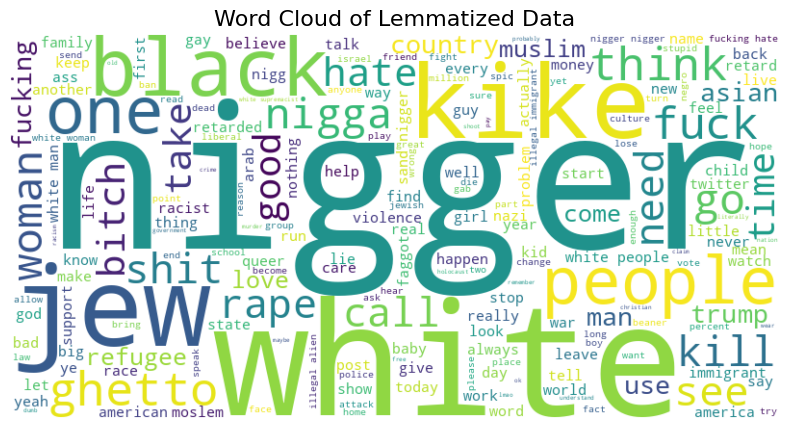

In [ ]:
#WordCloud for lemmatized field

# Combine all text into one string
all_text = ' '.join(final_data['lemmatized'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Lemmatized Data", fontsize=16)
plt.show()


In [ ]:
#computer Vader score

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate VADER scores
def compute_vader_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply VADER to the lemmatized text column
final_data['vader_scores'] = final_data['lemmatized'].apply(compute_vader_scores)

# Split VADER scores into separate columns
final_data['vader_neg'] = final_data['vader_scores'].apply(lambda x: x['neg'])
final_data['vader_neu'] = final_data['vader_scores'].apply(lambda x: x['neu'])
final_data['vader_pos'] = final_data['vader_scores'].apply(lambda x: x['pos'])
final_data['vader_compound'] = final_data['vader_scores'].apply(lambda x: x['compound'])

# Drop the combined VADER scores dictionary if not needed
final_data = final_data.drop(columns=['vader_scores'])

# Display updated DataFrame
final_data.head()


,target,text,label,lemmatized,pos_tags,vader_neg,vader_neu,vader_pos,vader_compound
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (all, DET), (nigger...",0.694,0.306,0.000,-0.7783
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (...",0.161,0.839,0.000,-0.3182
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB...",0.519,0.481,0.000,-0.8957
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ...",0.284,0.567,0.149,-0.3818
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (...",0.000,1.000,0.000,0.0000


# Vectorize the Lemmatized Text

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Use top 5000 features for efficiency

# Fit and transform the lemmatized text
lemmatized_tfidf = tfidf.fit_transform(final_data['lemmatized'])

# Convert TF-IDF matrix to a DataFrame
lemmatized_tfidf_df = pd.DataFrame(lemmatized_tfidf.toarray(), columns=tfidf.get_feature_names_out())


# One hot encoding for pos_tags

In [ ]:
pip install ace_tools

In [ ]:
from collections import Counter

# Function to count POS tags
def count_pos_tags(pos_tags):
    # Count the occurrences of each POS tag
    pos_counts = Counter([pos for _, pos in pos_tags])
    return pos_counts

# Apply POS tag counting to the 'pos_tags' column
final_data['pos_counts'] = final_data['pos_tags'].apply(count_pos_tags)

# Extract individual POS counts as separate columns
# Define the POS tags you want to track
pos_list = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN']

# Create separate columns for each POS type
for pos in pos_list:
    final_data[pos] = final_data['pos_counts'].apply(lambda x: x.get(pos, 0))

# Drop the intermediate 'pos_counts' column
final_data.drop('pos_counts', axis=1, inplace=True)


print("POS tag counts added as features.")
final_data.head()


POS tag counts added as features.


,target,text,label,lemmatized,pos_tags,vader_neg,vader_neu,vader_pos,vader_compound,NOUN,VERB,ADJ,ADV,PRON,PROPN
0,ethnicity,nawt yall niggers ignoring,0,nawt you all nigger ignore,"[(nawt, PROPN), (y, PRON), (all, DET), (nigger...",0.694,0.306,0.000,-0.7783,1,1,0,0,1,1
1,ethnicity,bit confused coz chinese ppl access twitter th...,1,bit confused coz chinese ppl access twitter th...,"[(bit, NOUN), (confused, ADJ), (coz, PROPN), (...",0.161,0.839,0.000,-0.3182,3,1,2,0,0,7
2,ethnicity,laura loomer raped screaming disgusting kike l...,1,laura loomer rape scream disgusting kike langu...,"[(laura, PROPN), (loomer, PROPN), (raped, VERB...",0.519,0.481,0.000,-0.8957,2,3,2,0,0,6
3,ethnicity,end nigger trainee doctors speak properly lack...,1,end nigg trainee doctor speak properly lack ba...,"[(end, NOUN), (nigger, ADJ), (trainee, NOUN), ...",0.284,0.567,0.149,-0.3818,6,3,3,2,0,0
4,ethnicity,nogs jews dykes enriching,1,nog jews dyke enrich,"[(nogs, NOUN), (jews, PROPN), (dykes, VERB), (...",0.000,1.000,0.000,0.0000,1,2,0,0,0,1


# Combine all the features

In [ ]:
import pandas as pd

# Combine POS counts, NER features, and VADER sentiment scores
combined_features = pd.concat([
    lemmatized_tfidf_df,  # TF-IDF features
    final_data[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']],  # VADER sentiment scores
    final_data[['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'PROPN']],  # POS tag counts
    final_data[['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'LANGUAGE']]  # NER features
], axis=1)

# Check the shape of the combined features
print(f"Final feature matrix shape: {combined_features.shape}")


Final feature matrix shape: (10651, 5019)


# Split the dataset as test and training set

In [ ]:
y = final_data['label']  # Target labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (8520, 5019)
Testing set size: (2131, 5019)


# Train the Model

# 1. Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train logistic regression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8582824964805256

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1051
           1       0.90      0.81      0.85      1080

    accuracy                           0.86      2131
   macro avg       0.86      0.86      0.86      2131
weighted avg       0.86      0.86      0.86      2131



# 2. Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

# Initialize SVM
svm = SVC(kernel='linear', probability=True)

# Train the model
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


NameError: name 'accuracy_score' is not defined

In [ ]:
from sklearn.svm import SVC

# Initialize SVM
svm = SVC(kernel='rbf', probability=True)

# Train the model
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


SVM Accuracy: 0.8423275457531675

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.85      1051
           1       0.92      0.75      0.83      1080

    accuracy                           0.84      2131
   macro avg       0.85      0.84      0.84      2131
weighted avg       0.86      0.84      0.84      2131



# 5. XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Convert Pandas DataFrames to NumPy arrays
X_train = X_train.values
X_test = X_test.values
# Initialize XGBoost
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred = xgboost.predict(X_test)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:45:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8568747067104646

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1051
           1       0.90      0.81      0.85      1080

    accuracy                           0.86      2131
   macro avg       0.86      0.86      0.86      2131
weighted avg       0.86      0.86      0.86      2131

